## Step 1: load data

In [1]:
%load_ext autoreload
%autoreload 2

from utils import *
from dual import *

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
def data_prep(data):
    data_size = len(data.index)

    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # code categories to -1/1
    gender_encoder = LabelEncoder()
    y = np.array(gender_encoder.fit_transform(y))
    y = y * 2 - 1

    # normalize data
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.fit(X)
    X = np.array(scaler.transform(X))
    
    return X, y

In [3]:
from sklearn import svm
from sklearn.model_selection import train_test_split
data_airline = pd.read_csv('airline_data.csv').dropna()

data_size = len(data_airline.index)

X_full = data_airline.iloc[:, :-1]
y_full = data_airline.iloc[:, -1]

sat_encoder = LabelEncoder()
y_full = np.array(sat_encoder.fit_transform(y_full))
y_full = y_full * 2 - 1

X_full['Gender'] = sat_encoder.fit_transform(X_full.Gender.values)
X_full['Customer Type'] = sat_encoder.fit_transform(X_full['Customer Type'].values)
X_full['Type of Travel'] = sat_encoder.fit_transform(X_full['Type of Travel'].values)
X_full['Class'] = sat_encoder.fit_transform(X_full['Class'].values)

X_full = X_full.drop(labels=["Unnamed: 0"], axis=1)
X_full = X_full.drop(labels=["id"], axis=1)

X_full = X_full[['Flight Distance', 'Departure Delay in Minutes', 'Gender', 'Class']]

'''
'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
'Flight Distance',
'Arrival Delay in Minutes', 'Departure Delay in Minutes', 'Inflight wifi service',
'Departure/Arrival time convenient', 'Ease of Online booking',
'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
'Inflight entertainment', 'On-board service', 'Leg room service',
'Baggage handling', 'Checkin service', 'Inflight service',
'Cleanliness']]
'''

scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(X_full)
X_full = np.array(scaler.transform(X_full))
#X_full = X_full[:,0:12]

In [4]:
data_airline.shape

(129487, 25)

In [5]:
#X_full, y_full = data_prep(data_airline_full)
#X_full = X_full[:,:8]
X, X_test, y, y_test = train_test_split(X_full, y_full, train_size=500, random_state=42)

In [6]:
X.shape

(500, 4)

## step 2: get normal SVM models

In [6]:
C_vals = np.logspace(-2.5, -1, 10)

models = list()

for index, cval in enumerate(C_vals):
    print(index,end='/')
    models.append(svm.SVC(kernel='linear', C=cval, probability=False))
    models[index].fit(X, y)

#save_file('models_air_500_4_-2.5_-1_10',models)

0/1/2/3/4/5/6/7/8/9/

In [7]:
C_vals = np.logspace(-2.5, -1, 10)
models = load_file('models_air_500_4_-2.5_-1_10')

In [8]:
msizes=[]
bounds=[]
risks=[]
emp_risks=[]
for model in models:
    w = np.array(model.coef_[0])
    margin_size = 1 / np.sqrt(np.sum(w ** 2))
    
    C = model.get_params()['C']
    emp_risk = (y != model.predict(X)).sum()/X.shape[0]
    risk = (y_test != model.predict(X_test)).sum()/X_test.shape[0]
    
    risks.append(risk)
    emp_risks.append(emp_risk)
    
    print(C, margin_size, model.intercept_[0], emp_risk, risk, sep='\t')
    msizes.append(margin_size)
    bounds.append(np.abs(model.intercept_[0]))

0.0031622776601683794	3.9857514523125994	-0.9114768131277593	0.404	0.4346174420678053
0.004641588833612777	2.715460853696826	-0.870065731141354	0.404	0.4346174420678053
0.006812920690579615	1.850021943461007	-0.8092825753302713	0.404	0.4346174420678053
0.01	1.260405277663181	-0.7200651037470047	0.322	0.3640521913061006
0.01467799267622069	0.8587041194707232	-0.5891117642979924	0.244	0.25961531007000704
0.021544346900318832	0.7025618764134111	-0.6126527692571242	0.242	0.24834285625683208
0.03162277660168379	0.6173399568499366	-0.7746659339935551	0.242	0.2483273508182995
0.046415888336127774	0.5287541082034757	-0.9704669984180674	0.242	0.2483273508182995
0.06812920690579612	0.5003514405195557	-1.0063659343319074	0.242	0.2483273508182995
0.1	0.5001671325240719	-1.0019693526629792	0.242	0.2483273508182995


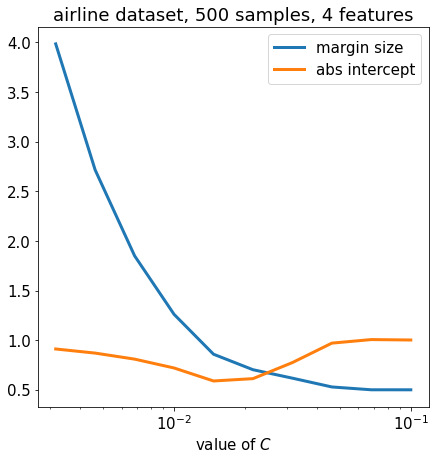

In [9]:
plt.figure(figsize=(7,7))
plt.rcParams.update({'font.size': 15})
plt.xscale('log')
plt.xlabel(r'value of $C$')
plt.plot(C_vals, msizes, label="margin size", lw=3)
plt.plot(C_vals, bounds, label="abs intercept", lw=3)
plt.legend()
plt.title("airline dataset, 500 samples, 4 features")

plt.savefig("images/margin-vs-c1.png")

plt.show()

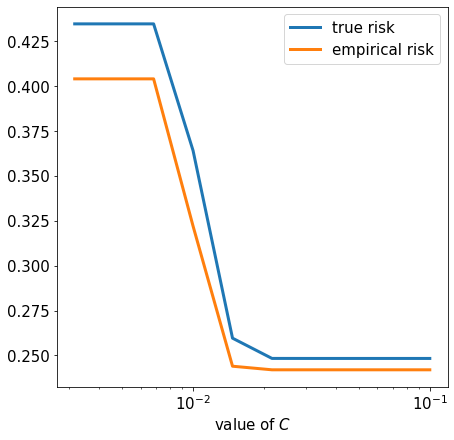

In [10]:
plt.figure(figsize=(7,7))
plt.xscale('log')
plt.xlabel(r'value of $C$')

plt.plot(C_vals, risks, label="true risk", lw=3)
plt.plot(C_vals, emp_risks, label="empirical risk", lw=3)
plt.legend()
plt.savefig("images/margin-vs-c2.png")

plt.show()

In [61]:
models

[SVC(C=0.001, kernel='linear'),
 SVC(C=0.0011233240329780276, kernel='linear'),
 SVC(C=0.0012618568830660211, kernel='linear'),
 SVC(C=0.0014174741629268048, kernel='linear'),
 SVC(C=0.0015922827933410922, kernel='linear'),
 SVC(C=0.001788649529057435, kernel='linear'),
 SVC(C=0.002009233002565048, kernel='linear'),
 SVC(C=0.002257019719633919, kernel='linear'),
 SVC(C=0.0025353644939701114, kernel='linear'),
 SVC(C=0.002848035868435802, kernel='linear'),
 SVC(C=0.0031992671377973846, kernel='linear'),
 SVC(C=0.003593813663804626, kernel='linear'),
 SVC(C=0.004037017258596553, kernel='linear'),
 SVC(C=0.004534878508128582, kernel='linear'),
 SVC(C=0.0050941380148163806, kernel='linear'),
 SVC(C=0.00572236765935022, kernel='linear'),
 SVC(C=0.006428073117284319, kernel='linear'),
 SVC(C=0.007220809018385464, kernel='linear'),
 SVC(C=0.008111308307896872, kernel='linear'),
 SVC(C=0.009111627561154887, kernel='linear'),
 SVC(C=0.010235310218990263, kernel='linear'),
 SVC(C=0.0114975699539

## step 3: calc rademacher of confidence

In [11]:
folder_name = "final_air500_4_-2.5_-1_10"

In [66]:
runs_per_sample = 10
maxiter = 100
init_temp = 5500
accept = -5

pump_cycles = 1

m = X.shape[0]
m

500

In [67]:
for pc in range(pump_cycles):

    for index, model in enumerate(models):
        
        print('\n', index, ':', pc, '///', end=' ')
        
        # sample X and Y sets of size m from the whole set
        
        PUMP_X = pd.DataFrame(X_full).sample(m, replace=False)
        PUMP_Y = y_full[PUMP_X.index]
        
        # get margin size and bound on intercept
        
        w = np.array(model.coef_[0])
        mar = 1 / np.sqrt(np.sum(w ** 2))
        b = np.abs(model.intercept_[0])
        
        
        
        # generate rademacher vector
        radvec = [rd.randint(0, 1) * 2 - 1 for x in range(m)]
        
        #################
        ## Calculate Confidence Rademacher Complexity
        print('conf', end=' ')
        
        DATA_SAVE_NAME = 'histories/'+folder_name+'/'+str(index)+'_Rconfidence'

        try:
            history1 = load_file(DATA_SAVE_NAME)
        except:
            print('new file')
            history1 = RDhistory('confidence')

        pump_rademacher(PUMP_X, PUMP_Y,
                        history=history1,
                        radvec=radvec,
                        runs_per_sample=1,
                        margin=1.0, bounds=b,
                        verbose=False)

        save_file(DATA_SAVE_NAME, history1)
        
        
        #################
        ## Calculate Margin loss Rademacher Complexity
        print('mloss', end=' ')
        
        DATA_SAVE_NAME = 'histories/'+folder_name+'/'+str(index)+'_Rmarginloss'

        try:
            history2 = load_file(DATA_SAVE_NAME)
        except:
            print('new file', end=' ')
            history2 = RDhistory('margin_loss')

        pump_rademacher(PUMP_X, PUMP_Y,
                        history=history2,
                        radvec=radvec,
                        runs_per_sample=runs_per_sample,
                        margin=mar, bounds=b,
                        verbose=False,
                        method='da', kwargs={'maxiter':maxiter, 'initial_temp':init_temp, 'accept':accept})

        save_file(DATA_SAVE_NAME, history2)
        
        #################
        ## Calculate Outlier Func
        print('out', end=' ')
        
        DATA_SAVE_NAME = 'histories/'+folder_name+'/'+str(index)+'_Outlier'

        try:
            history3 = load_file(DATA_SAVE_NAME)
        except:
            print('creating new file')
            history3 = list()

        res = solve_outlier(X_full, y_full, PUMP_X, PUMP_Y, mar, b,
                kwargs={'maxiter':maxiter, 'initial_temp':init_temp, 'accept':accept})
        history3.append(-res.fun)

        save_file(DATA_SAVE_NAME, history3)
        
        


 0 : 0 /// conf mloss out 
 1 : 0 /// conf mloss out 
 2 : 0 /// conf mloss out 
 3 : 0 /// conf mloss out 
 4 : 0 /// conf mloss out 
 5 : 0 /// conf mloss out 
 6 : 0 /// conf mloss out 
 7 : 0 /// conf mloss out 
 8 : 0 /// conf mloss out 
 9 : 0 /// conf mloss out 

## aggregate constants

In [23]:
from utils import _margin_loss

confs = [] #
rads = [] # 
outliers = [] #
true_risks = [] #
emp_mloss = [] #
true_mloss = [] #
margins = []
true_risks = []
emp_risks = []
for index, model in enumerate(models):
    confs.append(calc_complexity(load_file('histories/'+folder_name+'/'+str(index)+'_Rconfidence')))
    rads.append(calc_complexity(load_file('histories/'+folder_name+'/'+str(index)+'_Rmarginloss')))
    outliers.append(np.mean(load_file('histories/'+folder_name+'/'+str(index)+'_Outlier')))

    true_risks.append( (y_test != model.predict(X_test)).sum()/X_test.shape[0] )
    emp_risks.append( (y != model.predict(X)).sum()/X.shape[0] )
    
    w = np.array(model.coef_[0])
    margin_size = 1 / np.sqrt(np.sum(w ** 2))
    b = model.intercept_
    
    emp_mloss.append( np.mean(_margin_loss(w, b, margin_size, X, y)) )
    true_mloss.append( np.mean(_margin_loss(w, b, margin_size, X_test, y_test)) )
    margins.append(margin_size)
    

In [24]:
print(len(load_file('histories/'+folder_name+'/'+str(index)+'_Rmarginloss').rademacher))

1350


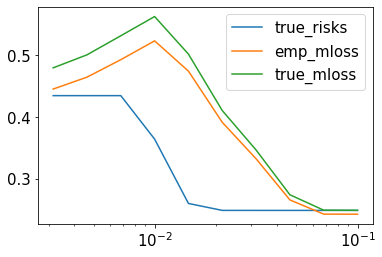

In [25]:
plt.plot(C_vals,true_risks, label='true_risks')
plt.plot(C_vals,emp_mloss, label='emp_mloss')
plt.plot(C_vals,true_mloss, label='true_mloss')

plt.xscale('log')
plt.legend()

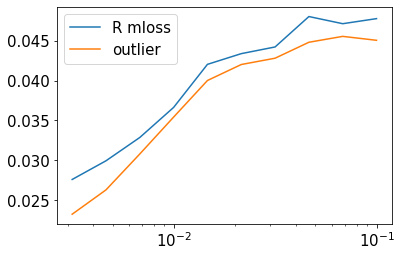

In [26]:
plt.plot(C_vals,rads, label='R mloss')
plt.plot(C_vals,outliers, label='outlier')

plt.xscale('log')
plt.legend()

## aggregate formulas

(1) True risk <

(2) true_mloss <

(3) emp_risk + outlier + sqrt(log(1/delta)/2m) <

(4) emp_risk + 2 * rad_mloss + sqrt(log(1/delta)/2m) <

(5) emp_risk + 2/rho * conf + sqrt(log(1/delta)/2m)

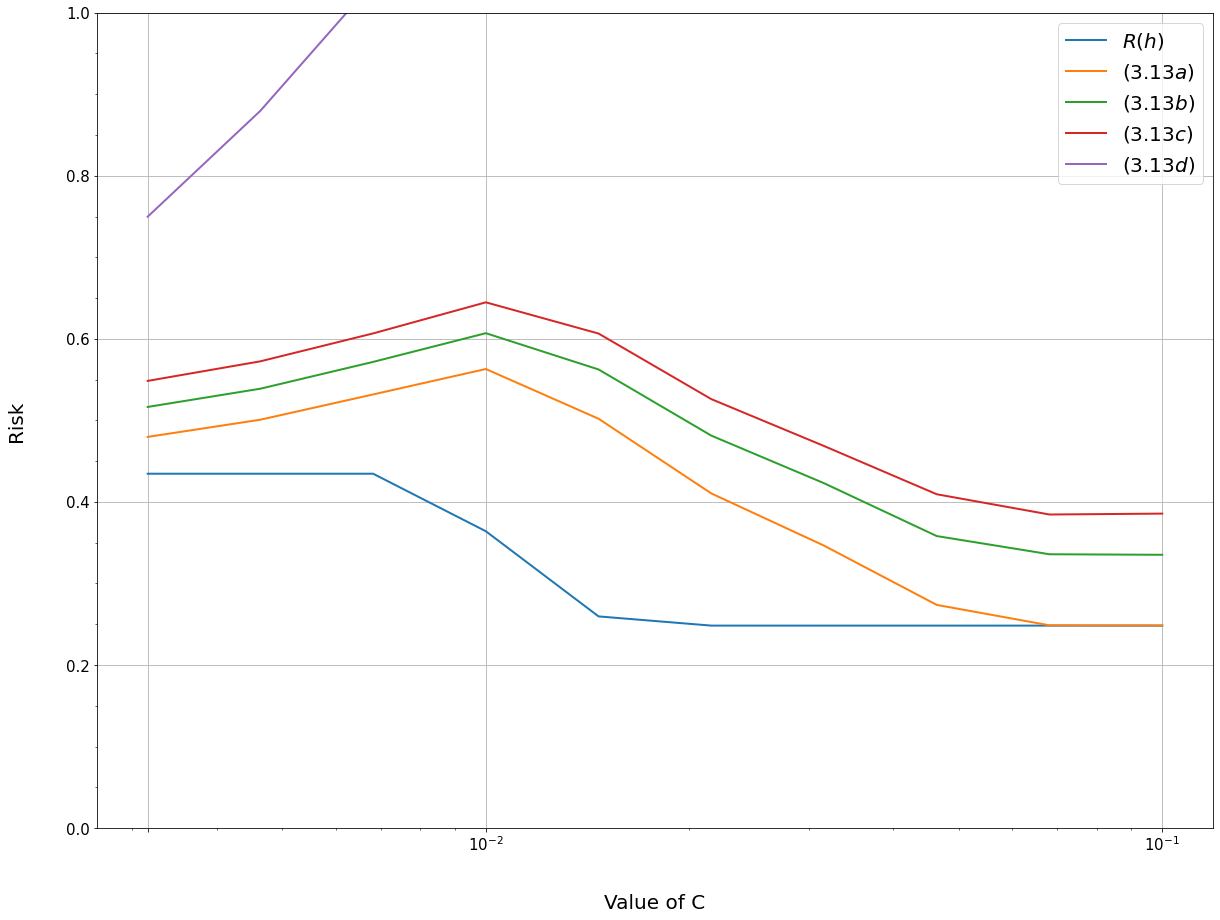

In [27]:
import matplotlib.cm as cm
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=[20,15])

color_val = 0.2
cmain = cm.Oranges(color_val)
csub = cm.Blues(color_val)

delta = 0.1

f1 = true_risks
f2 = true_mloss
f3 = np.array(emp_mloss) + np.array(outliers) + np.sqrt(np.log(1/delta)/(2*m))
f4 = np.array(emp_mloss) + 2 * np.array(rads) + np.sqrt(np.log(1/delta)/(2*m))
f5 = np.array(emp_mloss) + (2 / np.array(margins)) * np.array(confs) + np.sqrt(np.log(1/delta)/(2*m))

'''
plt.plot(C_vals, f1, lw=2, label=r'$R(h)$')
plt.plot(C_vals, f2, lw=2, label=r'$\mathbb{E}(\Phi_\rho(yh(x)))$')
plt.plot(C_vals, f3, lw=2, label=r'$\^{R}_{S,p}(h) + \mathbb{E}(\Phi(S)) + \sqrt{\frac{log\frac{1}{\delta}}{2m}}$')
plt.plot(C_vals, f4, lw=2, label=r'$\^{R}_{S,p}(h) + 2\mathfrak{R}_\mathfrak{m}(\Phi_\rho \circ \tilde{H}) + \sqrt{\frac{log\frac{1}{\delta}}{2m}} $')
plt.plot(C_vals, f5, lw=2, label=r'$\^{R}_{S,p}(h) + \frac{2}{\rho}\mathfrak{R}_\mathfrak{m}(H) + \sqrt{\frac{log\frac{1}{\delta}}{2m}} $')
'''

plt.plot(C_vals, f1, lw=2, label=r'$R(h)$')
plt.plot(C_vals, f2, lw=2, label=r'$(3.13a)$')
plt.plot(C_vals, f3, lw=2, label=r'$(3.13b)$')
plt.plot(C_vals, f4, lw=2, label=r'$(3.13c)$')
plt.plot(C_vals, f5, lw=2, label=r'$(3.13d)$')


plt.ylim(0,1)
plt.xscale('log')
#plt.xlim(-0.5,2.5)

ax.minorticks_on()
ax.grid(True, which='major')
#ax.xticks( C_vals )

ax.xaxis.set_major_locator(MultipleLocator(0.5))
#ax.yaxis.set_major_locator(MultipleLocator(0.1))

#ax.xaxis.set_minor_locator(AutoMinorLocator(0.5))
#ax.yaxis.set_minor_locator(AutoMinorLocator(0.05))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
#ax.grid(which='major', color='#CCCCCC', linestyle='--')
#ax.grid(which='minor', color='#CCCCCC', linestyle=':',lw=3)

plt.xticks([C_vals[0], 1e-2, 1e-1], fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=20, loc='upper right')

plt.xlabel("Value of C", fontsize=20, labelpad=40)
plt.ylabel("Risk", fontsize=20, labelpad=40)
#plt.title(r'Comparison of risk bounds', fontsize=20, pad=40)

plt.savefig("images/FINAL_AIR_4_500_C.png", bbox_inches='tight')

plt.show()


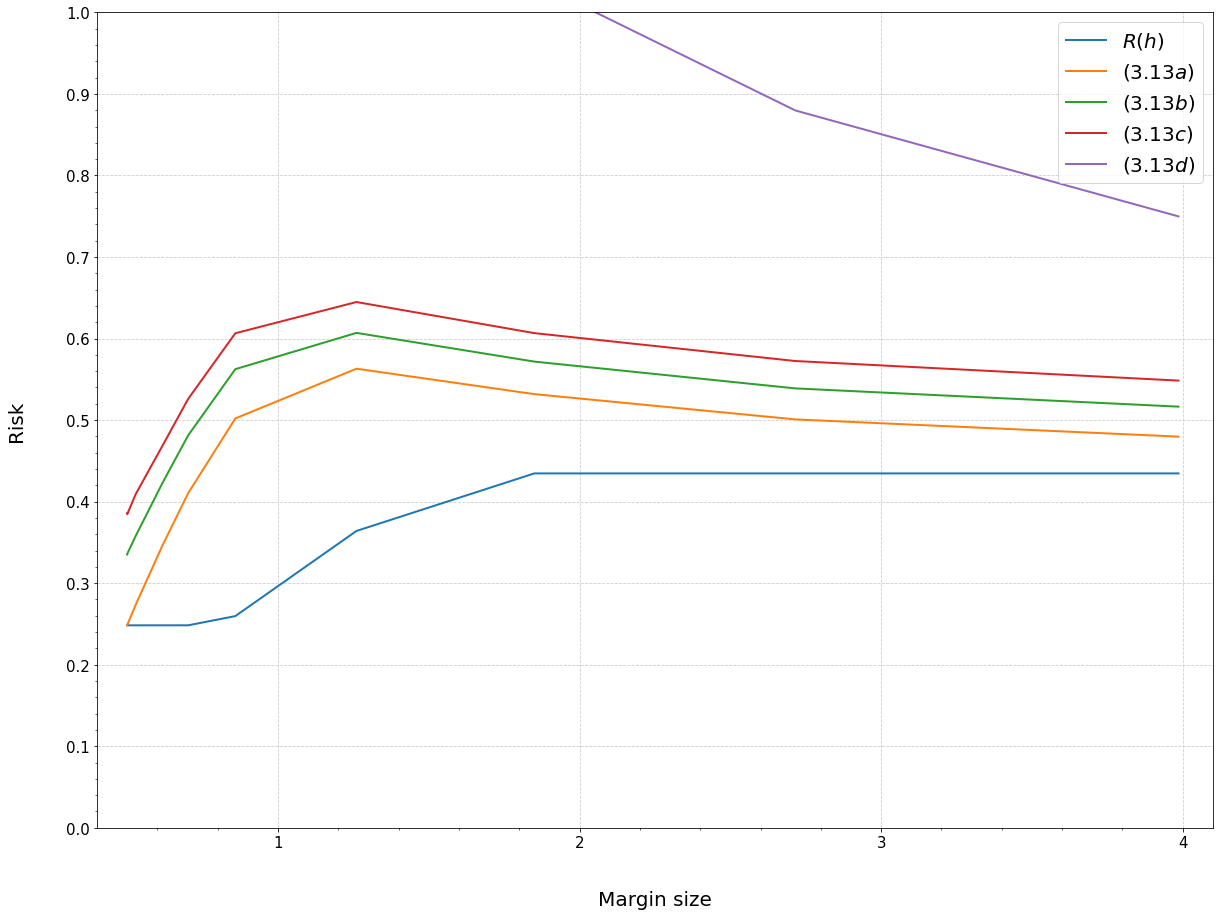

In [28]:
import matplotlib.cm as cm
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=[20,15])

color_val = 0.2
cmain = cm.Oranges(color_val)
csub = cm.Blues(color_val)

delta = 0.1

f1 = true_risks
f2 = true_mloss
f3 = np.array(emp_mloss) + np.array(outliers) + np.sqrt(np.log(1/delta)/(2*m))
f4 = np.array(emp_mloss) + 2 * np.array(rads) + np.sqrt(np.log(1/delta)/(2*m))
f5 = np.array(emp_mloss) + (2 / np.array(margins)) * np.array(confs) + np.sqrt(np.log(1/delta)/(2*m))

'''
plt.plot(margins, f1, lw=2, label=r'$R(h)$')
plt.plot(margins, f2, lw=2, label=r'$\mathbb{E}(\Phi_\rho(yh(x)))$')
plt.plot(margins, f3, lw=2, label=r'$\^{R}_{S,p}(h) + \mathbb{E}(\Phi(S)) + \sqrt{\frac{log\frac{1}{\delta}}{2m}}$')
plt.plot(margins, f4, lw=2, label=r'$\^{R}_{S,p}(h) + 2\mathfrak{R}_\mathfrak{m}(\Phi_\rho \circ \tilde{H}) + \sqrt{\frac{log\frac{1}{\delta}}{2m}} $')
plt.plot(margins, f5, lw=2, label=r'$\^{R}_{S,p}(h) + \frac{2}{\rho}\mathfrak{R}_\mathfrak{m}(H) + \sqrt{\frac{log\frac{1}{\delta}}{2m}} $')
'''


plt.plot(margins, f1, lw=2, label=r'$R(h)$')
plt.plot(margins, f2, lw=2, label=r'$(3.13a)$')
plt.plot(margins, f3, lw=2, label=r'$(3.13b)$')
plt.plot(margins, f4, lw=2, label=r'$(3.13c)$')
plt.plot(margins, f5, lw=2, label=r'$(3.13d)$')

plt.ylim(0,1)
#plt.xscale('log')
plt.xlim(0.4,4.1)

ax.minorticks_on()
ax.grid(True, which='major')
#ax.xticks( C_vals )

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

#ax.xaxis.set_minor_locator(AutoMinorLocator(0.5))
#ax.yaxis.set_minor_locator(AutoMinorLocator(0.05))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
#ax.grid(which='minor', color='#CCCCCC', linestyle=':',lw=3)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=20, loc='upper right')

plt.xlabel("Margin size", fontsize=20, labelpad=40)
plt.ylabel("Risk", fontsize=20, labelpad=40)
#plt.title(r'Comparison of risk bounds', fontsize=20, pad=40)

plt.savefig("images/FINAL_AIR_4_500_M.png", bbox_inches='tight')

plt.show()


In [29]:
true_mloss

[0.47974784284956107,
 0.5008598112827565,
 0.5318479430870614,
 0.5630242332499156,
 0.5020166109723649,
 0.4104466428588854,
 0.34640112985531735,
 0.2737315030019126,
 0.24867036430081432,
 0.24848505722456746]

In [30]:
for i in range(10):
    print("{:.4f}".format(C_vals[i]),
          "&", "{:.4f}".format(margins[i]),
          "&", "{:.4f}".format(true_risks[i]),
          "&", "{:.4f}".format(true_mloss[i]),
          "&", "{:.4f}".format(outliers[i]),
          "&", "{:.4f}".format(rads[i]),
          "&", "{:.4f}".format(confs[i]), "\\\\")

0.0032 & 3.9858 & 0.4346 & 0.4797 & 0.0232 & 0.0276 & 0.5112 \\
0.0046 & 2.7155 & 0.4346 & 0.5009 & 0.0263 & 0.0299 & 0.4985 \\
0.0068 & 1.8500 & 0.4346 & 0.5318 & 0.0308 & 0.0329 & 0.4588 \\
0.0100 & 1.2604 & 0.3641 & 0.5630 & 0.0354 & 0.0366 & 0.4313 \\
0.0147 & 0.8587 & 0.2596 & 0.5020 & 0.0400 & 0.0420 & 0.3548 \\
0.0215 & 0.7026 & 0.2483 & 0.4104 & 0.0420 & 0.0434 & 0.3580 \\
0.0316 & 0.6173 & 0.2483 & 0.3464 & 0.0428 & 0.0442 & 0.4479 \\
0.0464 & 0.5288 & 0.2483 & 0.2737 & 0.0448 & 0.0480 & 0.5439 \\
0.0681 & 0.5004 & 0.2483 & 0.2487 & 0.0456 & 0.0471 & 0.5701 \\
0.1000 & 0.5002 & 0.2483 & 0.2485 & 0.0451 & 0.0478 & 0.5434 \\


In [33]:
len(load_file('histories/'+folder_name+'/'+str(index)+'_Rmarginloss').rademacher)

1350

In [35]:
c, dist = calc_complexity(load_file('histories/'+folder_name+'/'+str(index)+'_Rmarginloss'), dist=True)

(array([ 1.,  1.,  0.,  1.,  1.,  0.,  2.,  1.,  2.,  3.,  2.,  3.,  3.,
         8.,  5.,  4.,  4.,  5.,  6., 11., 14., 20., 13., 13., 13.,  8.,
        14., 24., 22., 23., 26., 26., 30., 29., 37., 34., 34., 36., 36.,
        32., 28., 29., 36., 36., 39., 32., 34., 21., 38., 29., 34., 35.,
        41., 25., 29., 18., 27., 18., 24., 22., 14., 16., 13., 17., 18.,
        19.,  9., 11.,  9., 10.,  3.,  7.,  7.,  6.,  4.,  7.,  8.,  2.,
         2.,  3.,  2.,  2.,  2.,  1.,  3.,  6.,  1.,  1.,  2.,  0.,  2.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-3.57620940e-02, -3.38851481e-02, -3.20082023e-02, -3.01312565e-02,
        -2.82543107e-02, -2.63773649e-02, -2.45004190e-02, -2.26234732e-02,
        -2.07465274e-02, -1.88695816e-02, -1.69926358e-02, -1.51156900e-02,
        -1.32387441e-02, -1.13617983e-02, -9.48485250e-03, -7.60790668e-03,
        -5.73096086e-03, -3.85401504e-03, -1.97706922e-03, -1.00123401e-04,
         1.77682242e-03,  3.65376824e-03,  5.53071406e

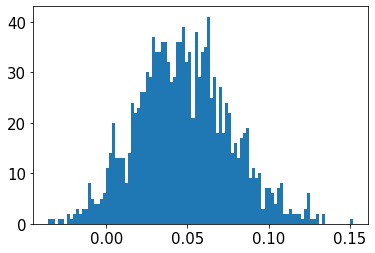

In [51]:
plt.hist(dist/500, bins=100)

In [54]:
(np.var(dist/500)**2) / (1350 * 0.0001**2)

0.05214580436133196

In [55]:
np.var(dist/500)**2

7.039683588779815e-07

In [62]:
np.array([7.0e-07]).astype(float)

array([7.e-07])

In [64]:
np.var(load_file('histories/'+folder_name+'/'+str(index)+'_Outlier'))

0.00014491042424687897

(array([ 2.,  2.,  1.,  9.,  2.,  5.,  3.,  6., 13.,  5., 11., 15.,  9.,
        21., 23., 14., 19., 23., 26., 25., 23., 34., 39., 25., 28., 36.,
        28., 28., 33., 41., 26., 26., 29., 34., 36., 40., 38., 25., 20.,
        36., 19., 27., 16., 33., 28., 18., 18., 19., 24., 17., 20., 23.,
        19., 18., 16., 11., 14., 15., 11., 11.,  9.,  9.,  9., 10.,  7.,
         4.,  8.,  8.,  4.,  3.,  5.,  4.,  2.,  2.,  4.,  2.,  5.,  5.,
         1.,  3.,  2.,  2.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([0.0190017 , 0.0197298 , 0.02045791, 0.02118601, 0.02191411,
        0.02264222, 0.02337032, 0.02409842, 0.02482653, 0.02555463,
        0.02628274, 0.02701084, 0.02773894, 0.02846705, 0.02919515,
        0.02992326, 0.03065136, 0.03137946, 0.03210757, 0.03283567,
        0.03356377, 0.03429188, 0.03501998, 0.03574809, 0.03647619,
        0.03720429, 0.0379324 , 0.0386605 , 0.03938861, 0.04011671,
        0.04084481, 0.0415

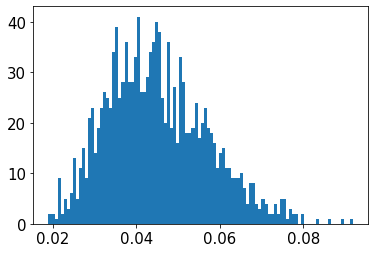

In [65]:
plt.hist(load_file('histories/'+folder_name+'/'+str(index)+'_Outlier'), bins=100)